# Predicting Wide Receiver Scores for Fantasy Football
### Overview
This project aims to predict the fantasy football scores of NFL wide receivers. It scrapes individual player receiving and team passing data from pro-football-reference.com for the 2000–2016 seasons (n=~2200). The data is cleaned and merged prior to feature engineering. The final dataset is transformed using principal component analysis (PCA) and then modeled using linear regression with k-fold cross validation.

### Key Questions Explored
- Can the model accurately predict NFL wide receiver fantasy scores?
- Which features correlate strongly with next season's fantasy points?

### Key Findings
- The final regression model following dimensionality reduction has an average root-mean-squared-error (RMSE) and R^2 value of 2.512 and 0.680 respectively. Using 10-fold cross-validation, the average RMSE and R^2 values were 2.544 and 0.670 for out-of-sample data. 

- For context of the MSE, the top wide-receiver prediction is ~17 fantasy points per game (FP/g), while the 30th ranked wide-receiver is predicted to score ~10 FP/g. Considering the small sample sizes for each season (16 games) and volatility of fantasy football performances, these predictions are relatively accurate.

### Techniques used
- pandas and numpy for data scraping, exploration, and cleaning
- sklearn for principal component dimensionality reduction, regression modeling, and k-fold cross validation
- seaborn and matplotlib for visualization

# Scrape Player, and Team Data

### Importing relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
import re
pd.options.mode.chained_assignment = None

### Function to Scrape and Load Data

In [2]:
def data_load(year_start, year_end, url, read_list):
    
    df = pd.DataFrame()
    years = reversed(range(year_start, year_end+1))
    
    for year in years:
        year = str(year)
        url_year = url.format(year)
        f = pd.read_html(url_year, header=0)
        f[read_list]['year'] = year
        df = df.append(f)
    df = df.reset_index(drop=True)
    return df

### Player Data
This cell uses the data_load function to scrape player receiving data from pro-football-reference.com for the 2000–2016 seasons.

In [5]:
year_start = 2000
year_end = 2016

url_player = 'https://www.pro-football-reference.com/years/{0}/receiving.htm'
data_player = data_load(year_start, year_end, url_player, 0)

### Team Data
This cell uses the data_load function to scrape team passing data from footballdb.com for the 2000–2016 seasons. This data will be merged with the receiving data to give context about the player's quarterback and team passing statistics.

In [6]:
url_team = 'http://www.footballdb.com/stats/teamstat.html?lg=NFL&yr={0}&type=reg&cat=P&group=O&conf='
data_team = data_load(year_start, year_end, url_team, 0)

# Cleaning the Datasets

### Cleaning Player Data
As shown below, the scraped data has oddities, such as an unnamed column for the player name, symbols on the player name, and rows that are out of order. The following cells will: (1) rename the player column, (2) rearrange the columns, and (3) clean up any non-numeric or standard string symobls.

In [7]:
print(data_player.shape)
data_player.head()

(7676, 18)


,Rk,Unnamed: 1,Tm,Age,Pos,G,GS,Tgt,Rec,Ctch%,Yds,Y/R,TD,Lng,R/G,Y/G,Fmb,year
0,1,Larry Fitzgerald*,ARI,33,WR,16,16,150,107,71.3%,1023,9.6,6,33,6.7,63.9,2,2016
1,2,Antonio Brown*+,PIT,28,WR,15,15,154,106,68.8%,1284,12.1,12,51,7.1,85.6,0,2016
2,3,Odell Beckham*,NYG,24,WR,16,16,169,101,59.8%,1367,13.5,10,75,6.3,85.4,3,2016
3,4,Julian Edelman,NWE,30,WR,16,13,159,98,61.6%,1106,11.3,3,77,6.1,69.1,3,2016
4,5,Jordy Nelson,GNB,31,WR,16,16,152,97,63.8%,1257,13.0,14,60,6.1,78.6,1,2016


In [8]:
data_player = data_player.rename(columns={'Unnamed: 1': 'Player'})
col_order = ['Player', 'Tm', 'Pos', 'year', 'Age', 'Ctch%', 'Fmb', 'G', 'GS', 'Lng',
             'R/G', 'Rec','TD', 'Tgt', 'Y/G', 'Y/R', 'Yds']
df_player = data_player[col_order]
df_player = df_player[pd.notnull(df_player['Player'])]

There were two players named Steve Smith that caused downstream issues. Only one player was relevant for this studies purpose, so these cells select the relevant Steve Smith, while filtering out the other. 

In [9]:
steve_smith = df_player[(df_player.Player == 'Steve Smith') & ((df_player.Tm == 'NYG') | (df_player.Tm == 'STL') | (df_player.Tm == 'PHI'))]
df_player = df_player.drop(steve_smith.index).reset_index(drop=True)
print(df_player.shape)
df_player[df_player.Player == "Steve Smith"]

(7431, 17)


,Player,Tm,Pos,year,Age,Ctch%,Fmb,G,GS,Lng,R/G,Rec,TD,Tgt,Y/G,Y/R,Yds
34,Steve Smith,BAL,WR,2016,37,69.3%,0,14,14,52,5.0,70,5,101,57.1,11.4,799
554,Steve Smith,BAL,wr,2015,36,63.0%,0,7,7,50,6.6,46,3,73,95.7,14.6,670
964,Steve Smith,BAL,WR,2014,35,59.0%,1,16,16,80,4.9,79,6,134,66.6,13.5,1065
1438,Steve Smith,CAR,WR,2013,34,58.2%,0,15,15,44,4.3,64,4,110,49.7,11.6,745
1874,Steve Smith,CAR,WR,2012,33,53.3%,1,16,16,66,4.6,73,4,137,73.4,16.1,1174
2844,Steve Smith,CAR,WR,2010,31,46.0%,3,14,14,39,3.3,46,2,100,39.6,12.0,554
3236,Steve Smith,CAR,WR,2009,30,50.4%,1,15,15,66,4.3,65,7,129,65.5,15.1,982
4093,Steve Smith,CAR,WR,2007,28,58.8%,1,15,15,74,5.8,87,7,148,66.8,11.5,1002
5664,Steve Smith,CAR,wr,2004,25,66.7%,0,1,1,15,6.0,6,0,9,60.0,10.0,60
5805,Steve Smith,CAR,WR,2003,24,62.0%,5,16,11,67,5.5,88,7,142,69.4,12.6,1110


In [10]:
def name_clean(col):
    char_remove = re.sub('[\*\+\%\,]', '', str(col))
    return char_remove

In [11]:
df_player['Player'] = df_player.Player.apply(name_clean)
df_player['Ctch%'] = df_player['Ctch%'].apply(name_clean)
print(df_player.shape)
df_player.head()

(7431, 17)


,Player,Tm,Pos,year,Age,Ctch%,Fmb,G,GS,Lng,R/G,Rec,TD,Tgt,Y/G,Y/R,Yds
0,Larry Fitzgerald,ARI,WR,2016,33,71.3,2,16,16,33,6.7,107,6,150,63.9,9.6,1023
1,Antonio Brown,PIT,WR,2016,28,68.8,0,15,15,51,7.1,106,12,154,85.6,12.1,1284
2,Odell Beckham,NYG,WR,2016,24,59.8,3,16,16,75,6.3,101,10,169,85.4,13.5,1367
3,Julian Edelman,NWE,WR,2016,30,61.6,3,16,13,77,6.1,98,3,159,69.1,11.3,1106
4,Jordy Nelson,GNB,WR,2016,31,63.8,1,16,16,60,6.1,97,14,152,78.6,13.0,1257


### Cleaning Team Data
As shown in the dataframe below, the team data also has an oddity in that it adds the city name after the nickname. The following cells will again rearrange the column order, followed by using regular expressions to split the strings and return only standard team names.

In [12]:
print(data_team.shape)
data_team.head()

(542, 14)


,Team,Gms,Att,Cmp,Pct,Yds,TD,Int,Sack,Loss,Rate,NetYds,Yds/G,year
0,New Orleans SaintsNew Orleans,16,674,472,70.0,5258,38,15,27,184,102.5,5074,317.1,2016
1,Washington RedskinsWashington,16,607,407,67.1,4948,25,12,23,190,97.4,4758,297.4,2016
2,Atlanta FalconsAtlanta,16,537,374,69.6,4960,38,7,37,235,116.8,4725,295.3,2016
3,New England PatriotsNew England,16,550,368,66.9,4456,32,2,24,148,109.5,4308,269.2,2016
4,Indianapolis ColtsIndianapolis,16,584,370,63.4,4491,32,15,44,289,94.5,4202,262.6,2016


In [13]:
col_order_team = ['Team', 'year', 'Yds', 'Att', 'Cmp', 'Int', 'Loss', 'Pct', 'Rate', 'Sack', 'TD']
df_team = data_team[col_order_team]
print(df_team.shape)
df_team.head()

(542, 11)


,Team,year,Yds,Att,Cmp,Int,Loss,Pct,Rate,Sack,TD
0,New Orleans SaintsNew Orleans,2016,5258,674,472,15,184,70.0,102.5,27,38
1,Washington RedskinsWashington,2016,4948,607,407,12,190,67.1,97.4,23,25
2,Atlanta FalconsAtlanta,2016,4960,537,374,7,235,69.6,116.8,37,38
3,New England PatriotsNew England,2016,4456,550,368,2,148,66.9,109.5,24,32
4,Indianapolis ColtsIndianapolis,2016,4491,584,370,15,289,63.4,94.5,44,32


The code below splits the team name at each capital letter and separates each word into its own string within a list. It then selects only unique strings (eliminating the duplicate city) and returns a joined string with the proper name, as shown below.

In [14]:
def unique_list(list_strings):
    ulist = []
    [ulist.append(x) for x in list_strings if x not in ulist]
    return ulist

team_names = []
for team in df_team.Team:
    name_separate = re.sub(r"(\w)([A-Z])", r"\1 \2", team)
    team_name = ' '.join(unique_list(name_separate.split()))
    team_names.append(team_name)
    
df_team['Team'] = team_names
df_team.head()

,Team,year,Yds,Att,Cmp,Int,Loss,Pct,Rate,Sack,TD
0,New Orleans Saints,2016,5258,674,472,15,184,70.0,102.5,27,38
1,Washington Redskins,2016,4948,607,407,12,190,67.1,97.4,23,25
2,Atlanta Falcons,2016,4960,537,374,7,235,69.6,116.8,37,38
3,New England Patriots,2016,4456,550,368,2,148,66.9,109.5,24,32
4,Indianapolis Colts,2016,4491,584,370,15,289,63.4,94.5,44,32


# Replace Full Team Name with Abbreviation
In order to merge the player and team dataframes together, the team listed for the player must match the team name in the team stats dataframe. Unfortunately, the team stats dataframe uses the full name, while the player dataframe uses the teams' abbreviations. This section will create a dictionary that matches the team abbreviation to the full team name, which will be mapped to each dataframe.

In [15]:
player_team_sort = pd.DataFrame(df_player.Tm.unique(), columns=['abb']).sort_values('abb')
player_team_sort = player_team_sort[2:].reset_index(drop=True)

team_sort = pd.DataFrame(df_team.Team.unique(), columns=['full']).sort_values('full').reset_index(drop=True)

team_names = pd.concat([player_team_sort, team_sort], axis=1)
team_names

,abb,full
0,ARI,Arizona Cardinals
1,ATL,Atlanta Falcons
2,BAL,Baltimore Ravens
3,BUF,Buffalo Bills
4,CAR,Carolina Panthers
5,CHI,Chicago Bears
6,CIN,Cincinnati Bengals
7,CLE,Cleveland Browns
8,DAL,Dallas Cowboys
9,DEN,Denver Broncos


The dataframe above using alphabetical ordering of the team abbreviations and full team names matches the majority of teams correctly. However, a few are out of order and will need to be replaced manually, below.

In [16]:
team_names.loc[19, 'full'] = 'New Orleans Saints'
team_names.loc[20, 'full'] = 'New England Patriots'
team_names.loc[27, 'full'] = 'Seattle Seahawks'
team_names.loc[28, 'full'] = 'San Francisco 49ers'
team_names

,abb,full
0,ARI,Arizona Cardinals
1,ATL,Atlanta Falcons
2,BAL,Baltimore Ravens
3,BUF,Buffalo Bills
4,CAR,Carolina Panthers
5,CHI,Chicago Bears
6,CIN,Cincinnati Bengals
7,CLE,Cleveland Browns
8,DAL,Dallas Cowboys
9,DEN,Denver Broncos


Now that all teams are correctly matched, the dataframe can be made into a dictionary, with the full team name as the key and the abbreviation as a value. This dictionary will then be used with the map function to change all full team names in the team stats dataframe to team abbreviations that match the players.

In [17]:
team_dict = team_names.set_index('full', drop=True).to_dict()
team_dict['abb']

{'Arizona Cardinals': 'ARI',
 'Atlanta Falcons': 'ATL',
 'Baltimore Ravens': 'BAL',
 'Buffalo Bills': 'BUF',
 'Carolina Panthers': 'CAR',
 'Chicago Bears': 'CHI',
 'Cincinnati Bengals': 'CIN',
 'Cleveland Browns': 'CLE',
 'Dallas Cowboys': 'DAL',
 'Denver Broncos': 'DEN',
 'Detroit Lions': 'DET',
 'Green Bay Packers': 'GNB',
 'Houston Texans': 'HOU',
 'Indianapolis Colts': 'IND',
 'Jacksonville Jaguars': 'JAX',
 'Kansas City Chiefs': 'KAN',
 'Los Angeles Rams': 'LAR',
 'Miami Dolphins': 'MIA',
 'Minnesota Vikings': 'MIN',
 'New England Patriots': 'NWE',
 'New Orleans Saints': 'NOR',
 'New York Giants NY': 'NYG',
 'New York Jets NY': 'NYJ',
 'Oakland Raiders': 'OAK',
 'Philadelphia Eagles': 'PHI',
 'Pittsburgh Steelers': 'PIT',
 'San Diego Chargers': 'SDG',
 'San Francisco 49ers': 'SFO',
 'Seattle Seahawks': 'SEA',
 'St. Louis Rams': 'STL',
 'Tampa Bay Buccaneers': 'TAM',
 'Tennessee Titans': 'TEN',
 'Washington Redskins': 'WAS'}

In [18]:
df_team['Team'] = df_team.Team.map(team_dict['abb'])
df_team.head()

,Team,year,Yds,Att,Cmp,Int,Loss,Pct,Rate,Sack,TD
0,NOR,2016,5258,674,472,15,184,70.0,102.5,27,38
1,WAS,2016,4948,607,407,12,190,67.1,97.4,23,25
2,ATL,2016,4960,537,374,7,235,69.6,116.8,37,38
3,NWE,2016,4456,550,368,2,148,66.9,109.5,24,32
4,IND,2016,4491,584,370,15,289,63.4,94.5,44,32


As shown above, the team name was successfully changed to the abbreviated version. Now that the team names match the teams from the player dataframe, the two can be merged.

# Merging Player and Team Data into Single Dataframe
Below, the team dataframe will be merged with the player dataframe according to the teams and the year.

In [19]:
df_merged = pd.merge(df_player, df_team, how='left', left_on = ['Tm', 'year'], right_on = ['Team', 'year'])
df_merged.drop('Team', axis=1, inplace=True)
print(df_merged.shape)
print(df_merged.dtypes)
df_merged.head()

(7431, 26)
Player     object
Tm         object
Pos        object
year       object
Age        object
Ctch%      object
Fmb        object
G          object
GS         object
Lng        object
R/G        object
Rec        object
TD_x       object
Tgt        object
Y/G        object
Y/R        object
Yds_x      object
Yds_y     float64
Att       float64
Cmp       float64
Int       float64
Loss      float64
Pct       float64
Rate      float64
Sack      float64
TD_y      float64
dtype: object


,Player,Tm,Pos,year,Age,Ctch%,Fmb,G,GS,Lng,...,Yds_x,Yds_y,Att,Cmp,Int,Loss,Pct,Rate,Sack,TD_y
0,Larry Fitzgerald,ARI,WR,2016,33,71.3,2,16,16,33,...,1023,4425.0,646.0,383.0,17.0,289.0,59.3,83.5,41.0,28.0
1,Antonio Brown,PIT,WR,2016,28,68.8,0,15,15,51,...,1284,4377.0,596.0,381.0,15.0,175.0,63.9,93.9,21.0,33.0
2,Odell Beckham,NYG,WR,2016,24,59.8,3,16,16,75,...,1367,4027.0,598.0,377.0,16.0,148.0,63.0,86.0,22.0,26.0
3,Julian Edelman,NWE,WR,2016,30,61.6,3,16,13,77,...,1106,4456.0,550.0,368.0,2.0,148.0,66.9,109.5,24.0,32.0
4,Jordy Nelson,GNB,WR,2016,31,63.8,1,16,16,60,...,1257,4445.0,620.0,403.0,8.0,246.0,65.0,102.3,35.0,40.0


# Addressing Null Values
Now that the dataframes have merged, null values will be addressed. As shown below, the biggest category with null values is the position dataframe. Because these values were scraped from the receiving statistics of pro-football-focus, I will assume that the majority are wide-receivers who were not labeled properly. As a result, I will re-label them as wide-receivers and then filter out any other positions (e.g. runningback, tight end).

In [20]:
nulls = df_merged.isnull().sum()
nulls[nulls > 0]

Pos      1855
Age         2
Tgt         4
Yds_y     197
Att       197
Cmp       197
Int       197
Loss      197
Pct       197
Rate      197
Sack      197
TD_y      197
dtype: int64

In [21]:
df_merged['Pos'] = df_merged.Pos.fillna('WR')
wr_replace = {
    'wr': 'WR',
    'WR': 'WR',
    'fb/WR': 'WR'
}

df_merged.Pos = df_merged.Pos.map(wr_replace)
df_merged = df_merged[pd.notnull(df_merged['Pos'])]
df_merged.isnull().sum()

Player      0
Tm          0
Pos         0
year        0
Age         2
Ctch%       0
Fmb         0
G           0
GS          0
Lng         0
R/G         0
Rec         0
TD_x        0
Tgt         3
Y/G         0
Y/R         0
Yds_x       0
Yds_y     197
Att       197
Cmp       197
Int       197
Loss      197
Pct       197
Rate      197
Sack      197
TD_y      197
dtype: int64

The remaining null values stem from players that were traded in-season and have two teams listed instead of one (not shown). As a result, the mapping above could not match a team's stats and returned a null value. Rather than individually looking up each of these players / teams and manually entering the stats, the null values will simply be replaced with median values, leaving no null values in the dataset.

In [22]:
df_merged = df_merged.fillna(df_merged.median()).dropna()
df_merged.isnull().sum()[df_merged.isnull().sum() > 0]

Series([], dtype: int64)

# Creating New Features and Adding Target Values
This section will create new features that will help to improve the model prediction accuracy. The first cell creates simple fantasy point (FP) columns for each wide receiver, as well as a quarterback fantasy point (QB FP) score that indicates how many points the wide receiver's quarterback threw for. Finally, a fantasy points per game (FP/G) feature is added, which will ultimately be our target value for predictions.

In [23]:
Yd_mult = 0.1
TD_val = 7.0
Rec_val = 0.5
Fmb = -2.0

df_merged.loc[:, 'year':] = df_merged.loc[:,'year':].astype(float)

df_merged['FP'] = Yd_mult*df_merged['Yds_x'] + TD_val*df_merged['TD_x'] + Rec_val*df_merged['Rec'] + Fmb*df_merged['Fmb']
df_merged['QB FP'] = .04*df_merged['Yds_y'] + 5*df_merged['TD_y'] - 2*df_merged['Int'] - 1*df_merged['Sack']
df_merged['FP / G'] = df_merged['FP'] / df_merged['G']

The function below completes three main tasks: 
- Creates historical metrics for the current season, such as career median, mean, or max fantasy points. In order to complete this task, the dataframe loops through each year and computes the historical metrics for each prior season. Thus, the historical metrics are based on information known during that season. For example, the prior 2001-2009 data would be known for the 2010 season. 


- Creates age-based features so that younger vs. older players are properly accounted for. Younger players may not put up as many points as more established players, but players that perform better early in their careers typically have more prolific numbers as they mature. Further, players tend to decline in performance as they age (typically after 30 years old).


- Adds the target values (Y_act) for the upcoming season. For example, the data where year = 2010 will have the FP/G from 2011 as the Y_act value. This metric was chosen because it is most relevant for the use case of predicting the upcoming season. The user would know the 2010 data and all previous season data, but would want to predict the upcoming 2011 season results. The 2016 data thus will not have any Y_act values because the 2017 season is not yet complete (as of this writing September 2017). The final machine learning algorithm will be used to predict the upcoming season values.

In [24]:
def features_target(df, year_start, year_end, median_features, max_features, 
                    mean_features, age_features, target_feature):
    
    new_df = pd.DataFrame()
    years = range(year_start+7, year_end+1)

    for year in years:
        
        # adding the median features
        past = df[df['year'] <= year]
        for metric in median_features:
            past = past.join(past.groupby('Player')[metric].median(),on='Player', rsuffix='_median')
            
        for metric in max_features:
            past = past.join(past.groupby('Player')[metric].max(),on='Player', rsuffix='_max')
            
        for metric in mean_features:
            past = past.join(past.groupby('Player')[metric].mean(),on='Player', rsuffix='_mean')
            
        # adding the age features
        suffix = '/ age'
        for feature in age_features:
            feature_label = ' '.join([feature, suffix])
            past[feature_label] = past[feature] / past['Age']
        
        # adding the values for target feature
        year_n = past[past["year"] == year]
        year_n_plus_one = df[df['year'] == year+1][['Player', target_feature]].rename(columns={target_feature: 'Y_act'})
        year_n = pd.merge(year_n, year_n_plus_one, how='left', left_on='Player', right_on='Player')
        new_df = new_df.append(year_n)
    
    # creating dataframes to export
    new_df = new_df.sort_values(by=['year', 'FP'], ascending=[False, False])
    df_train_test = new_df[new_df.year < year_end].reset_index(drop=True)
    df_predict = new_df[new_df.year == year_end].drop('Y_act', axis=1).reset_index(drop=True)
    
    return df_train_test, df_predict

The list of features to be converted into median, max, mean, and age features are shown below. The output consists of a train / test dataframe that will be used for training and testing the model. The prediction dataframe will be the 2016 results that can be used to predict the upcoming 2017 season. The accuracy of these 2016 predictions cannot be computed yet because the season has not occurred, but can be compared to average draft rankings available online.

In [25]:
median_features = ['FP', 'FP / G', 'QB FP', 'TD_x', 'Y/G', 'Tgt', 'Rec']
max_features = ['FP', 'TD_x', 'Tgt', 'Y/G', 'Rec']
mean_features = ['FP', 'TD_x', 'Tgt', 'Y/G', 'Rec']
age_features = ['FP', 'FP / G', 'Y/G', 'FP_median', 'FP_max', 'Y/G_mean', 'FP_mean']

df_train_test_raw, df_predict = features_target(df_merged, year_start, year_end, median_features, 
                                                max_features, mean_features, age_features, 'FP / G')

In [26]:
print(df_train_test_raw.shape)
df_train_test_raw.head()

(2167, 54)


,Player,Tm,Pos,year,Age,Ctch%,Fmb,G,GS,Lng,...,Y/G_mean,Rec_mean,FP / age,FP / G / age,Y/G / age,FP_median / age,FP_max / age,Y/G_mean / age,FP_mean / age,Y_act
0,Antonio Brown,PIT,WR,2015.0,27.0,70.5,3.0,16.0,16.0,59.0,...,77.133333,87.666667,11.681481,0.730093,4.244444,7.744444,11.900000,2.856790,7.508025,17.693333
1,Julio Jones,ATL,WR,2015.0,26.0,67.0,3.0,16.0,16.0,70.0,...,97.560000,82.800000,11.734615,0.733413,4.496154,8.819231,11.734615,3.752308,8.070000,16.028571
2,Brandon Marshall,NYJ,WR,2015.0,31.0,63.0,3.0,16.0,16.0,69.0,...,73.530000,88.200000,9.570968,0.598185,3.029032,7.080645,9.570968,2.371935,6.733226,8.620000
3,DeAndre Hopkins,HOU,WR,2015.0,23.0,57.8,1.0,16.0,16.0,61.0,...,73.600000,79.666667,12.286957,0.767935,4.134783,8.565217,12.286957,3.200000,8.663768,10.150000
4,Odell Beckham,NYG,WR,2015.0,23.0,60.8,2.0,15.0,15.0,87.0,...,102.750000,93.500000,12.173913,0.811594,4.204348,11.695652,12.173913,4.467391,11.695652,15.700000


# Injury Replacement Values
One issue with the Y_act values is that many are null due to players not playing in the following season. Some reasons for the null values may include a season-ending injury during preseason or a retirement. To account for these null values, the Y_act will be replaced by the players median FP/G up to the season in question.

In [27]:
print(df_train_test_raw.isnull().sum()[df_train_test_raw.isnull().sum() > 0])
df_train_test_raw[df_train_test_raw.Y_act.isnull()].head(10)

Y_act    875
dtype: int64


,Player,Tm,Pos,year,Age,Ctch%,Fmb,G,GS,Lng,...,Y/G_mean,Rec_mean,FP / age,FP / G / age,Y/G / age,FP_median / age,FP_max / age,Y/G_mean / age,FP_mean / age,Y_act
9,Calvin Johnson,DET,WR,2015.0,30.0,59.1,1.0,16.0,16.0,57.0,...,85.755556,81.222222,7.546667,0.471667,2.530000,7.750000,10.870000,2.858519,7.705185,NaN
24,James Jones,GNB,WR,2015.0,31.0,50.5,1.0,16.0,15.0,65.0,...,42.655556,48.111111,5.419355,0.338710,1.793548,4.135484,6.722581,1.375986,4.063082,NaN
28,Rueben Randle,NYG,WR,2015.0,24.0,63.3,0.0,16.0,16.0,72.0,...,41.300000,47.000000,6.841667,0.427604,2.075000,5.581250,6.841667,1.720833,5.108333,NaN
36,Martavis Bryant,PIT,WR,2015.0,24.0,54.3,1.0,11.0,5.0,88.0,...,62.200000,38.000000,5.895833,0.535985,2.895833,5.529167,5.895833,2.591667,5.529167,NaN
44,Nate Washington,HOU,WR,2015.0,32.0,50.0,0.0,14.0,14.0,49.0,...,46.650000,49.250000,3.665625,0.261830,1.468750,3.812500,5.884375,1.457812,4.007812,NaN
49,Cole Beasley,DAL,WR,2015.0,26.0,69.3,2.0,16.0,3.0,30.0,...,24.725000,35.750000,4.253846,0.265865,1.288462,2.938462,4.253846,0.950962,2.727885,NaN
51,Charles Sims,TAM,WR,2015.0,25.0,72.9,2.0,16.0,0.0,56.0,...,29.450000,35.000000,4.224000,0.264000,1.404000,2.602000,4.224000,1.178000,2.602000,NaN
52,Shane Vereen,NYG,WR,2015.0,26.0,72.8,1.0,16.0,0.0,37.0,...,30.900000,59.000000,4.038462,0.252404,1.188462,4.038462,4.038462,1.188462,4.038462,NaN
54,Marques Colston,NOR,WR,2015.0,32.0,67.2,0.0,13.0,5.0,53.0,...,66.660000,71.100000,3.203125,0.246394,1.250000,6.064063,7.631250,2.083125,5.673125,NaN
61,Steve Johnson,SDG,WR,2015.0,29.0,69.2,1.0,10.0,8.0,34.0,...,42.450000,47.625000,3.144828,0.314483,1.713793,3.377586,7.458621,1.463793,3.865948,NaN


This function takes in all rows containing a null target Y_act value and replaces it with the median FP/G of the player.

In [28]:
def injury_replacement(df, full_season):
    
    df_replace = pd.DataFrame()
    
    if full_season == True:
        full_season_injuries = df[df.Y_act.isnull()]
        
        for i, row in full_season_injuries.iterrows():
            row['Y_act'] = row['FP / G_median']
            df_replace = df_replace.append(row)

        df_replace = df_replace[list(full_season_injuries.columns)]    
    
    df.loc[list(df_replace.index)] = df_replace
    return df

In [29]:
df_train_test = injury_replacement(df_train_test_raw, True)

# Exploring Features
With a clean dataset containing all relevant features, the correlations between each feature and the Y_act target value can be explored using seaborn's heatmap. Unsurprisingly, many of the engineered features are highly correlated with eachother and the features they were derived from. Somewhat surprisingly, the quarterback and team passing statistics do not strongly correlate with the receiver's statistics or the target Y_act value. 

In order to more clearly explore these relationships, the top 25 features will be selected and plotted in a second heatmap.

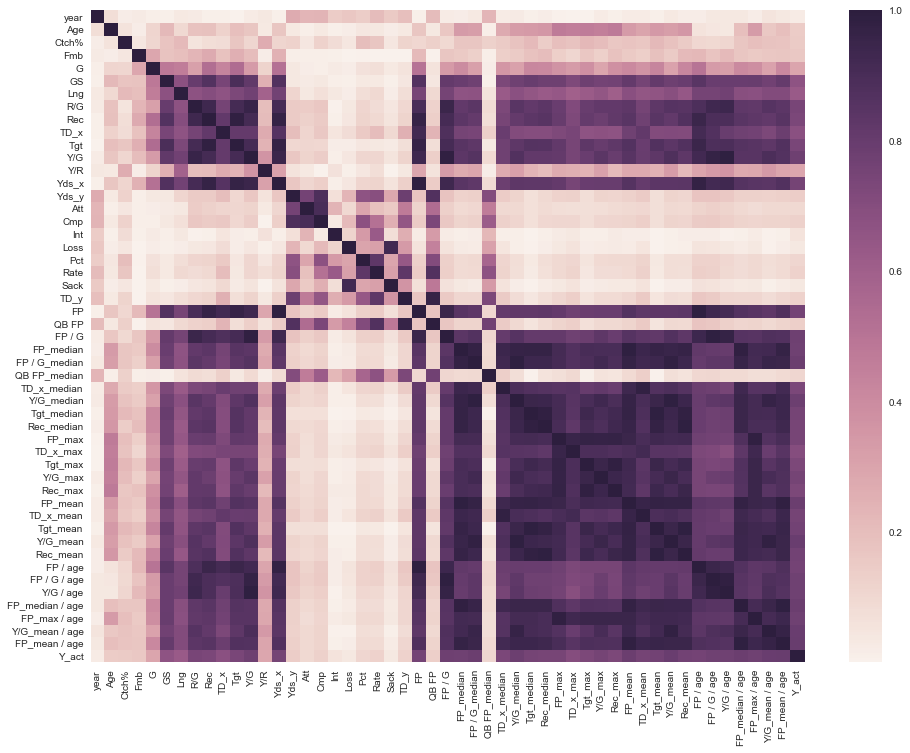

In [30]:
plt.figure(figsize=(16,12))
corrmat = abs(df_train_test.corr())
sns.heatmap(corrmat)

While many of the features shown below are highly correlated with the Y_act value (as high as 0.80 for the mean fantasy points scaled with age), it seems as though a lot of these features are redundant. The high multicolinearity with the dataset can lead to problems with certain machine learning algorithms. 

There are a number of techniques available to handle this situation (regularization, feature selection), but in this case I chose to use principal component analysis (PCA) for dimensionality reduction. Due to the extreme amount of multicollinearity, I hypothesized that the majority of variance in the dataset can be explained by only a few principal components. The next section will utilize PCA prior to regression modeling the dataset. 

When looking at the correlations, a few trends emerge in predicting the next year's fantasy points. It seems as though career fantasy points and yards per game with age taken into account are particularly important,. These correlations are unsurprising, as players with established track records are more likely to continue to perform. Touchdowns correlate less strongly with next year's fantasy points because they are more random than a player accumulating yards. Somewhat surprisingly, the player's quarterback does not strongly correlate with next year's fantasy points.

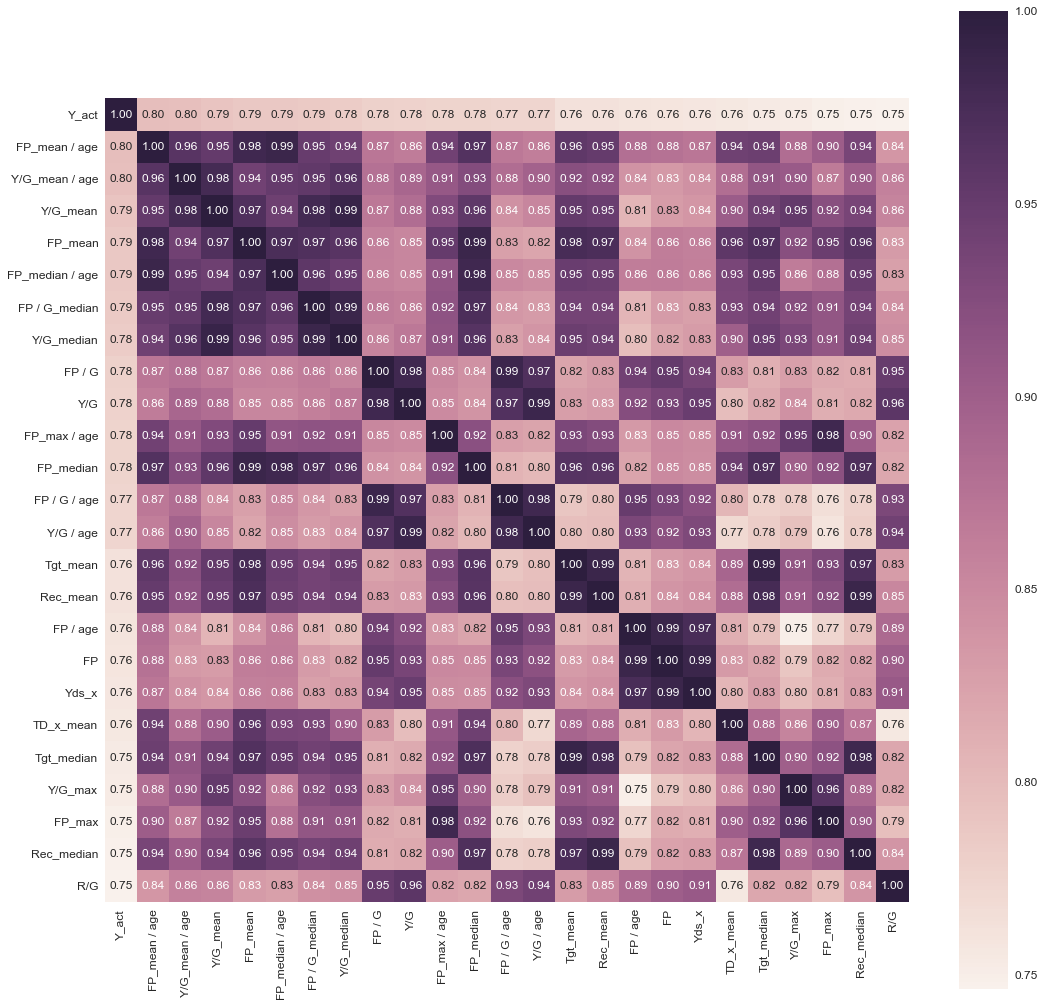

In [31]:
plt.figure(figsize=(18,18))
k = 25
cols_large = corrmat.nlargest(k, 'Y_act').index
hm_large = corrmat.nlargest(k,'Y_act')[cols_large]
sns.set(font_scale=1.2)
sns_plot = sns.heatmap(hm_large, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 12})

fig = sns_plot.get_figure()
fig.savefig('output.png') 

# Principal Component Analysis (PCA)
As discussed in the previous section, I will use PCA to decompose the dataset into independent principal components. The following function (PCA_convert) runs PCA on the train set, followed by using the exact same transformation on the test set and prediction set to prevent data leakage. It returns all three dataframes containing the PCA transformed values for the train, test, and prediction sets respectively. It also returns the fraction of variance explained by each principal component, which will be plotted later on. 

In [32]:
def PCA_convert(X_train, X_test, X_predict, params):
    
    from sklearn.decomposition import PCA
    
    ## normalizing the datasets using zero mean centered gaussians
    X_train_normal = (X_train.select_dtypes(include=['float']) - X_train.mean()) / X_train.std()
    X_test_normal = (X_test.select_dtypes(include=['float']) - X_test.mean()) / X_test.std()
    X_predict_normal = (X_predict.select_dtypes(include=['float']) - X_predict.mean()) / X_predict.std()
    
    del X_train_normal['year']
    del X_test_normal['year']
    del X_predict_normal['year']
    
    if params[1] == True:
        print("n_train: ", len(X_train_normal))
        print("n_test: ", len(X_test_normal))
        print("n_predict", len(X_predict_normal))
    
    ## PCA transformation
    pca = PCA(n_components=params[0])
    reduced = pca.fit_transform(X_train_normal)
    pca_var = pca.explained_variance_ratio_
    
    col_num = range(params[0])
    col_names = ['PC{0}'.format(num+1) for num in col_num]
    X_train_PCA = pd.DataFrame(reduced, columns=col_names)
    
    ## Transforming test set based on decomposition of train set
    X_test_PCA = pca.transform(X_test_normal.select_dtypes(include=['float']))
    X_test_PCA = pd.DataFrame(X_test_PCA, columns=col_names)

    ## Transforming prediction set based on decomposition of train set
    X_predict_PCA = pca.transform(X_predict_normal)
    X_predict_PCA = pd.DataFrame(X_predict_PCA, columns=col_names)
    
    return X_train_PCA, X_test_PCA, X_predict_PCA, pca_var

Below, the PCA conversion function is run using an example train/test split. The machine learning model will be run using K-fold cross validation, so the below code simply shows a demonstration of the function using a single train/test split.

In [33]:
from sklearn.model_selection import train_test_split

# params = PCA_components, print train/test size
params = [10, True]

# initializing train and test sets to demonstrate PCA
X_predict = df_predict
X_train, X_test, y_train, y_test = train_test_split(df_train_test.drop('Y_act', axis=1), 
                                                    df_train_test.Y_act, 
                                                    test_size = 0.25,
                                                    random_state = 1)

X_train_PCA, X_test_PCA, X_predict_PCA, pca_var = PCA_convert(X_train, X_test, X_predict, params)

n_train:  1625
n_test:  542
n_predict 265


Below is a funtion that plots the amount of variance explained by each subsequent principal component, as well as a heatmap showing the correlation of each principal component with each other and the Y_act target value. The plots shown below are only for the single train/test split in the previous cell, but are demonstrative of the expected results.

In [34]:
def pca_plot(X, y, pca_var):
    
    cum_var = [sum(pca_var[:i+1]) for i in range(len(pca_var))]
    num_comp = range(1,params[0]+1)
    plt.plot(num_comp, cum_var)
    plt.xlabel('n components')
    plt.ylabel('variance explained')
    plt.show()
        
    plt.figure(figsize=(14,10))
    y.reset_index(drop=True, inplace=True)
    full_df = pd.concat([X, y], axis=1)
    corrmat_PCA = abs(full_df.corr())
    k = len(num_comp) + 1
    cols_PCA = corrmat_PCA.nlargest(k, 'Y_act').index
    hm_large = corrmat_PCA.nlargest(k,'Y_act')[cols_PCA]
    sns.set(font_scale=1.2)
    sns_plot = sns.heatmap(hm_large, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12})
    plt.show()

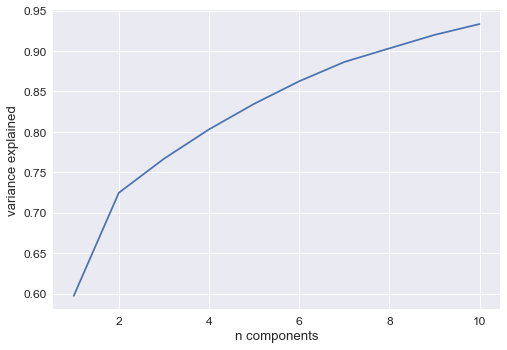

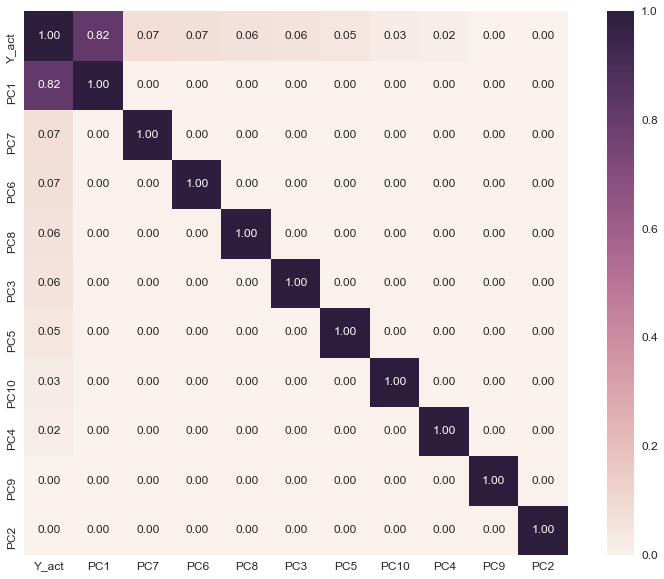

In [35]:
pca_plot(X_train_PCA, y_train, pca_var)

The above graph and heatmap shows that the vast majority of the explained variation (~60%) and correlation with the Y_act variable (0.82) is contained within the first principal component. The remaining principal components explain the remaining variance (up to ~95%) and have modest to no correlation with Y_act (0.0–0.07). Further, all multicollinearity between the features has been eliminated, as all principal components are linearly independent by definition. 

# Regression modeling of PCA output
Because all features are linearly independent principal components, predictions can be made using a simple linear regression model. The function below performs 3 main operations:
1. Splits the dataset using k-fold cross-validation and then passes the train and test datasets to the PCA_convert function from above for dimensionality reduction.
2. Trains the resulting PCA-converted training data using linear regression and makes predictions on the test data and the 2016 prediction data.
3. Calculates the root-mean-squared-error (RMSE) and R^2 values for both the training and test data. Each RMSE and R^2 value for each k-fold is averaged at the end to provide final error metrics.

In [51]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def kfold_validation_modeling(df, X_predict, target, folds, params):
    
    
    # creating empty lists to store error metrics for each k-fold iteration
    r_square_train = []
    r_square_test = []
    
    rmses_train = []
    rmses_test = []

    df_predictions = pd.DataFrame(X_predict['Player'])
    count = 1
    
    # initializing k-fold cross validation
    folds = KFold(n_splits=folds, shuffle=True, random_state=3)
    
    for train_index, test_index in folds.split(range(0, df.shape[0])):
        
        # using the train and test indices from k-fold split to subset train and test data
        X_train, X_test = df.iloc[train_index, :].drop(target, axis=1), df.iloc[test_index, :].drop(target, axis=1)
        y_train, y_test = df[target][train_index], df[target][test_index]
        y_train.reset_index(drop=True, inplace=True)
        y_test.reset_index(drop=True, inplace=True)
        
        # transforming resulting train and test data using PCA
        X_train_PCA, X_test_PCA, X_predict_PCA, pca_var = PCA_convert(X_train, X_test, X_predict, params)
        
        # training linear regression on PCA converted train data
        lr = LinearRegression()
        model = lr.fit(X_train_PCA, y_train)
        
        # calculating RMSE and R^2 error metrics for the training data
        train_pred = model.predict(X_train_PCA)
        rsq_train = model.score(X_train_PCA, y_train)
        r_square_train.append(rsq_train)
        rmse_train = np.sqrt(mean_squared_error(train_pred, y_train))
        rmses_train.append(rmse_train)
      
        # predicting the test data and calculating RMSE and R^2 error metric for the test set
        test_pred = model.predict(X_test_PCA)
        rsq_test = model.score(X_test_PCA, y_test)
        r_square_test.append(rsq_test)
        rmse_test = np.sqrt(mean_squared_error(test_pred, y_test))
        rmses_test.append(rmse_test)
        
        # making predictions for the upcoming 2017 season
        df_predictions[count] = model.predict(X_predict_PCA)
    
    df_predictions['mean'] = df_predictions.iloc[:,1:].mean(axis=1)

    #returning the average error metrics and dataframe containing next season's predictions
    return np.mean(r_square_train), np.mean(r_square_test), np.mean(rmses_train), np.mean(rmses_test), df_predictions

Using the function above, the data will be trained and tested using 10-fold cross-validation.

In [55]:
params = [20, False]
r2_train, r2_test, rmse_train, rmse_test, df_predictions = \
kfold_validation_modeling(df_train_test, df_predict, 'Y_act', 10, params)

Printing the average error metrics for the train and test data.

In [53]:
print('Train R^2:  ', round(r2_train, 3), ' *** ', 'Test R^2:  ', round(r2_test, 3))
print('Train RMSE: ', round(rmse_train, 3), ' *** ', 'Test RMSE: ', round(rmse_test, 3))

Train R^2:   0.68  ***  Test R^2:   0.67
Train RMSE:  2.512  ***  Test RMSE:  2.544


Looking at the RMSE and R^2 values for the train and test datasets shows that the model has relatively high accuracy for predicting next season's fantasy football scores. Because the RMSE and R^2 values are similar between the train and test sets, it appears that the model has achieved relatively sufficient bias/variance tradeoff.

### Making predictions for upcoming season
Finally, the PCA transformed data from the 2016 season can be used to predict the upcoming 2017 season statistics. The plot below shows the predicted fantasy points per game for the top 25 wide receivers. Comparing the top 10 wide receivers to standard average draft positions shows many of the same names, demonstrating the accuracy of the model without incorporating any average draft position data. Further, another analysis I conducted with averaged draft position, showed only ~49% R^2 accuracy, meaning this model may actually contain more accurate predictions. Once this upcoming season has completed, these predictions can be analyzed for their correctness and compared to standard predictions from other players and the fantasy football industry.

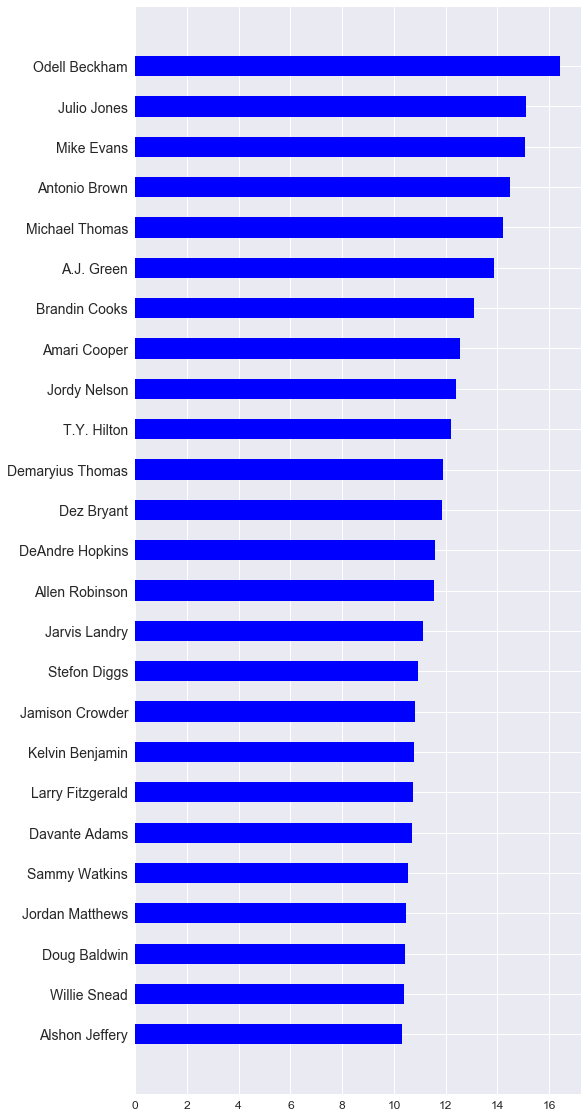

In [54]:
num_to_plot = 25

predictions = df_predictions.sort_values('mean', ascending=True).reset_index(drop=True)
length = len(predictions) - num_to_plot

fig = plt.figure(figsize=(8,20))
ax = fig.add_subplot(1,1,1)

to_plot = predictions.loc[length:,'mean']
ax.barh(range(len(predictions) - length), to_plot, 0.5,  color='blue',)

ax.set_yticks(range(num_to_plot))
ax.set_yticklabels(predictions.loc[length:,'Player'], fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()